In [14]:
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from lorenz import lorenz63
from utils import covariance, entrop_OMT

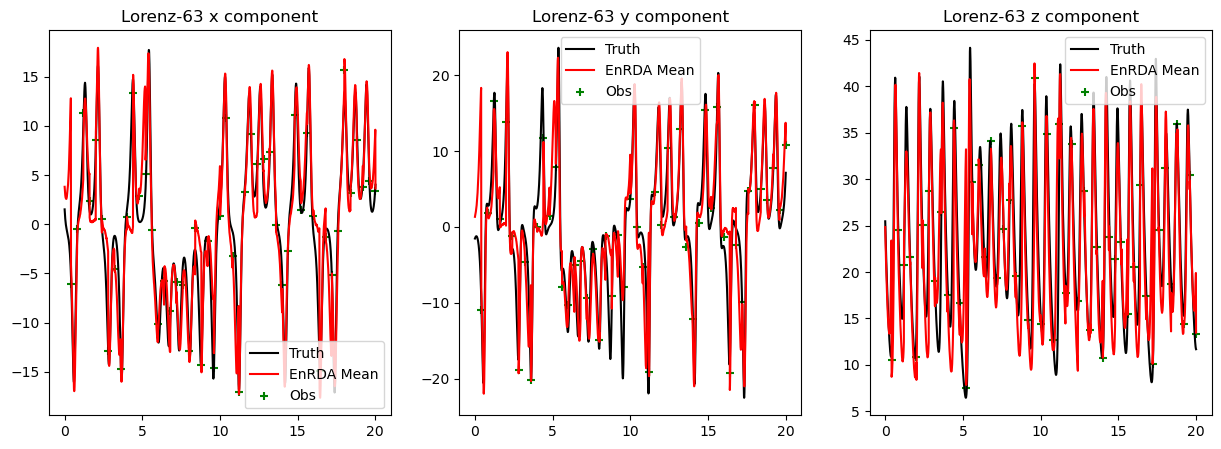

In [15]:
# Set JAX default random key
key = random.PRNGKey(0)

# Lorenz-63 parameters
parm = jnp.array([10.0, 28.0, 8/3])  # True system parameters
parm_sys = jnp.array([10.5, 27.0, 10/3])  # Model parameters
dt = 0.01
t_f = 20
tspan = jnp.arange(0, t_f + dt, dt)

# Initial true state
xtrue = jnp.array([1.508870, -1.531271, 25.46091])

# Noise parameters
gamma = 10.0
sig_mod = jnp.sqrt(2 * dt)
sig_init = jnp.sqrt(2)
sig_obs = jnp.sqrt(2)

N = 10  # Ensemble size
obs_int = int(40 * dt / dt)  # Observation interval
obs_num = jnp.arange(41, len(tspan), 40)

# Correlation matrix for observation noise
corr_mat = jnp.array([[1, 0.5, 0.25], [0.5, 1, 0.5], [0.25, 0.5, 1]])
Obs_cov = (sig_obs ** 2) * corr_mat
mod_cov = (sig_mod ** 2) * jnp.eye(3)

# Initialize ensemble
xa_EnRDA = jnp.zeros((len(tspan), 3, N))

# Initial ensemble
for j in range(N):
    noise = random.normal(key, (3,)) * sig_init
    xa_EnRDA = xa_EnRDA.at[0, :, j].set(xtrue + noise)

# Generate true trajectory
xtrue_traj = [xtrue]
for i in range(1, len(tspan)):
    xtrue = lorenz63(xtrue, dt, parm)
    xtrue_traj.append(xtrue)

xtrue_traj = jnp.array(xtrue_traj)

# Generate observations with noise
obs_noise = multivariate_normal.rvs(mean=jnp.zeros(3), cov=Obs_cov, size=len(obs_num))
Obs = xtrue_traj[obs_num] + obs_noise

# Data assimilation loop
count = 0
for i in range(1, len(tspan)):
    # Forecast step
    for j in range(N):
        model_noise = multivariate_normal.rvs(mean=jnp.zeros(3), cov=mod_cov)
        xa_EnRDA = xa_EnRDA.at[i, :, j].set(
            lorenz63(xa_EnRDA[i-1, :, j], dt, parm_sys) + model_noise
        )

    # Update step if observation is available
    if i in obs_num:
        x = xa_EnRDA[i].T  # Shape (3, N)
        px = jnp.ones(N) / N  # Uniform prior weights

        # Generate perturbed observations
        y = Obs[count] + multivariate_normal.rvs(mean=jnp.zeros(3), cov=Obs_cov, size=N)

        # Compute covariance matrix
        B = covariance(x, x)

        # Compute weight eta
        eta = jnp.trace(Obs_cov) / (jnp.trace(Obs_cov) + jnp.trace(B))

        # Compute transport plan
        py = jnp.ones(N) / N
        U = entrop_OMT(x.T, y.T, px, py, gamma, 300)

        # Resample ensemble members based on transport plan
        I, J = jnp.nonzero(U)
        U1 = U[I, J]

        rand_vals = random.uniform(key, shape=(N,))
        Xt = eta * x[I] + (1 - eta) * y[J]

        for j in range(N):
            idx = jnp.argmax(rand_vals[j] < jnp.cumsum(U1))
            xa_EnRDA = xa_EnRDA.at[i, :, j].set(Xt[idx])

        count += 1

# Compute ensemble mean
xa_EnRDA_mean = jnp.mean(xa_EnRDA, axis=2)

# Compute error metrics
mse_EnRDA = jnp.mean((xtrue_traj - xa_EnRDA_mean) ** 2)
bias_EnRDA = jnp.abs(jnp.mean(xtrue_traj - xa_EnRDA_mean))
ubrmse_EnRDA = jnp.sqrt(mse_EnRDA - bias_EnRDA ** 2)

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, label in enumerate(["x", "y", "z"]):
    axes[i].plot(tspan, xtrue_traj[:, i], color="k", label="Truth")
    axes[i].plot(tspan, xa_EnRDA_mean[:, i], color="r", label="EnRDA Mean")
    axes[i].scatter(tspan[obs_num], Obs[:, i], color="g", marker="+", label="Obs")
    axes[i].set_title(f"Lorenz-63 {label} component")
    axes[i].legend()

plt.show()
